In [1]:
import os

os.chdir('/Users/edwardchiu/Desktop/projects/baha-anime-analysis')
os.getcwd()

'/Users/edwardchiu/Desktop/projects/baha-anime-analysis'

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt


In [2]:
import yaml
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In [3]:
from transformers import BertTokenizer, BertModel
import torch

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")
model = BertModel.from_pretrained("hfl/chinese-roberta-wwm-ext")

In [ ]:
with open('conf/app.yml') as f:
    app_config = yaml.safe_load(f)

In [ ]:
url = 'https://ani.gamer.com.tw/animeVideo.php?sn=40525'
user_agent = app_config['website']['user_agent']
# ua = UserAgent()
# user_agent = ua.random
headers = {'User-Agent': user_agent}

In [ ]:
req = requests.get(url, headers=headers)
req

In [ ]:
soup = BeautifulSoup(req.text, 'html.parser')

In [ ]:
soup.select_one('.ACG-box1listB > li > a')

In [ ]:
intro = soup.select_one('.data-intro > p').text

In [ ]:
intro.split('\r＜')[0].strip()

In [ ]:
# Tokenize and encode the input text
inputs = tokenizer(intro, return_tensors="pt", truncation=True, max_length=512)
outputs = model(**inputs)

In [ ]:
outputs

In [ ]:
# Get the hidden states
hidden_states = outputs.last_hidden_state

In [ ]:
# Take the embedding of the [CLS] token (first token)
cls_embedding = hidden_states[:, 0, :]  # Shape: (batch_size, hidden_dim)

In [ ]:
cls_embedding.squeeze().detach().tolist()

In [23]:
def intro_feature_extraction(intro):
    try:
        # Tokenize and encode the input text
        inputs = tokenizer(intro, return_tensors="pt", truncation=True, max_length=512)
        outputs = model(**inputs)

        # Get the hidden states
        hidden_states = outputs.last_hidden_state

        # Take the embedding of the [CLS] token (first token)
        cls_embedding = hidden_states[:, 0, :]  # Shape: (batch_size, hidden_dim)
        feature = cls_embedding.squeeze().detach().tolist()
        return feature
    except:
        return None

In [24]:
df_all_anime = pd.read_csv('data/all_anime.csv')
df_all_anime.head()

,name,thumbnail,total_view,total_episode,avg_view,link,score,score_count,score_rate,first_launched_date,author,director,agent,animator,types,intro
0,青之壬生浪,https://p2.bahamut.com.tw/B/ACG/c/23/000013552...,36000.0,4,9000.0,https://ani.gamer.com.tw/animeRef.php?sn=113677,4.8,336.0,0.009333,2024-10-19,安田剛士,羽原久美子,曼迪,MAHO FILM,"['青春', '勵志', '歷史']",本作品以約160年前的幕末京都為舞台，描繪新選組的青春物語。因黑船來襲而動亂頻繁的幕末京都裡...
1,香蕉喵遊世界,https://p2.bahamut.com.tw/B/ACG/c/00/000014150...,21000.0,8,2625.0,https://ani.gamer.com.tw/animeRef.php?sn=113633,4.7,140.0,0.006667,2024-10-14,Q-LiA,矢立恭,Ani-One,TMS Entertainment（第6工作室）×Lesprit,"['溫馨', '悠閒', '泡麵番', '闔家觀賞']",在某座星球上，誕生了一隻不可思議的生物。牠的名字叫「香蕉喵」，是藏在香蕉裡的神秘小貓咪，沒有...
2,平凡職業造就世界最強 第三季,https://p2.bahamut.com.tw/B/ACG/c/96/000012709...,517000.0,5,103400.0,https://ani.gamer.com.tw/animeRef.php?sn=113635,4.9,4173.0,0.008072,2024-10-14,白米良,岩永彰,木棉花,asread.,"['動作', '冒險', '奇幻', '異世界', '魔法']",南雲始一行人打敗了神之使徒「諾因」，並順利擊退侵略王都的魔人族。在攻略剩餘的兩個大迷宮前，為...
3,香格里拉・開拓異境～糞作獵手挑戰神作～ 第二季,https://p2.bahamut.com.tw/B/ACG/c/12/000013861...,848000.0,5,169600.0,https://ani.gamer.com.tw/animeRef.php?sn=113665,5.0,6808.0,0.008028,2024-10-13,硬梨菜、不二涼介,窪岡俊之、池下博紀,木棉花,C2C,"['動作', '冒險', '奇幻']",「你是為了什麼而玩遊戲的？」\r如果世界上的遊戲有100款神作，那麼也就有存在著1000款糞...
4,魔王 2099,https://p2.bahamut.com.tw/B/ACG/c/43/000013124...,412000.0,5,82400.0,https://ani.gamer.com.tw/animeRef.php?sn=113662,4.9,3793.0,0.009206,2024-10-13,紫大悟,安藤良,木棉花,J.C.STAFF,"['動作', '奇幻', '魔法', '科幻', '職場']",這裡是統合曆2099年──新宿市。在被滅亡的500年後，傳說中的魔王「貝爾托爾」再次降臨於發...


In [25]:
df_all_anime['intro_feature'] = df_all_anime['intro'].apply(intro_feature_extraction)

In [26]:
df_all_anime.head()

,name,thumbnail,total_view,total_episode,avg_view,link,score,score_count,score_rate,first_launched_date,author,director,agent,animator,types,intro,intro_feature
0,青之壬生浪,https://p2.bahamut.com.tw/B/ACG/c/23/000013552...,36000.0,4,9000.0,https://ani.gamer.com.tw/animeRef.php?sn=113677,4.8,336.0,0.009333,2024-10-19,安田剛士,羽原久美子,曼迪,MAHO FILM,"['青春', '勵志', '歷史']",本作品以約160年前的幕末京都為舞台，描繪新選組的青春物語。因黑船來襲而動亂頻繁的幕末京都裡...,"[0.36482474207878113, 0.7688465118408203, 0.90..."
1,香蕉喵遊世界,https://p2.bahamut.com.tw/B/ACG/c/00/000014150...,21000.0,8,2625.0,https://ani.gamer.com.tw/animeRef.php?sn=113633,4.7,140.0,0.006667,2024-10-14,Q-LiA,矢立恭,Ani-One,TMS Entertainment（第6工作室）×Lesprit,"['溫馨', '悠閒', '泡麵番', '闔家觀賞']",在某座星球上，誕生了一隻不可思議的生物。牠的名字叫「香蕉喵」，是藏在香蕉裡的神秘小貓咪，沒有...,"[0.619700014591217, 0.0547364205121994, 0.3429..."
2,平凡職業造就世界最強 第三季,https://p2.bahamut.com.tw/B/ACG/c/96/000012709...,517000.0,5,103400.0,https://ani.gamer.com.tw/animeRef.php?sn=113635,4.9,4173.0,0.008072,2024-10-14,白米良,岩永彰,木棉花,asread.,"['動作', '冒險', '奇幻', '異世界', '魔法']",南雲始一行人打敗了神之使徒「諾因」，並順利擊退侵略王都的魔人族。在攻略剩餘的兩個大迷宮前，為...,"[0.42784765362739563, 0.8475140929222107, 0.77..."
3,香格里拉・開拓異境～糞作獵手挑戰神作～ 第二季,https://p2.bahamut.com.tw/B/ACG/c/12/000013861...,848000.0,5,169600.0,https://ani.gamer.com.tw/animeRef.php?sn=113665,5.0,6808.0,0.008028,2024-10-13,硬梨菜、不二涼介,窪岡俊之、池下博紀,木棉花,C2C,"['動作', '冒險', '奇幻']",「你是為了什麼而玩遊戲的？」\r如果世界上的遊戲有100款神作，那麼也就有存在著1000款糞...,"[0.7400757670402527, 0.7505607604980469, 0.541..."
4,魔王 2099,https://p2.bahamut.com.tw/B/ACG/c/43/000013124...,412000.0,5,82400.0,https://ani.gamer.com.tw/animeRef.php?sn=113662,4.9,3793.0,0.009206,2024-10-13,紫大悟,安藤良,木棉花,J.C.STAFF,"['動作', '奇幻', '魔法', '科幻', '職場']",這裡是統合曆2099年──新宿市。在被滅亡的500年後，傳說中的魔王「貝爾托爾」再次降臨於發...,"[-0.15343107283115387, 0.6935722231864929, 0.6..."


In [28]:
df_intro = df_all_anime[['name', 'intro', 'intro_feature']].dropna(ignore_index=True)
df_intro.head()

,name,intro,intro_feature
0,青之壬生浪,本作品以約160年前的幕末京都為舞台，描繪新選組的青春物語。因黑船來襲而動亂頻繁的幕末京都裡...,"[0.36482474207878113, 0.7688465118408203, 0.90..."
1,香蕉喵遊世界,在某座星球上，誕生了一隻不可思議的生物。牠的名字叫「香蕉喵」，是藏在香蕉裡的神秘小貓咪，沒有...,"[0.619700014591217, 0.0547364205121994, 0.3429..."
2,平凡職業造就世界最強 第三季,南雲始一行人打敗了神之使徒「諾因」，並順利擊退侵略王都的魔人族。在攻略剩餘的兩個大迷宮前，為...,"[0.42784765362739563, 0.8475140929222107, 0.77..."
3,香格里拉・開拓異境～糞作獵手挑戰神作～ 第二季,「你是為了什麼而玩遊戲的？」\r如果世界上的遊戲有100款神作，那麼也就有存在著1000款糞...,"[0.7400757670402527, 0.7505607604980469, 0.541..."
4,魔王 2099,這裡是統合曆2099年──新宿市。在被滅亡的500年後，傳說中的魔王「貝爾托爾」再次降臨於發...,"[-0.15343107283115387, 0.6935722231864929, 0.6..."


In [37]:
# Extract feature vectors as a 2D array
df_sub = df_intro[:100]
features = np.vstack(df_sub['intro_feature'])
features

array([[ 0.36482474,  0.76884651,  0.90308213, ..., -1.18455124,
        -0.38091949, -0.17436117],
       [ 0.61970001,  0.05473642,  0.34294593, ..., -0.42090085,
        -0.36328405,  0.22187349],
       [ 0.42784765,  0.84751409,  0.773552  , ..., -1.27783716,
        -0.2895748 , -0.25041488],
       ...,
       [-0.21834737,  0.62666517,  0.69224459, ..., -0.66052604,
        -0.5069378 ,  0.1752315 ],
       [ 0.79407352,  1.14008629,  1.31402373, ..., -0.64428401,
        -0.3424871 ,  0.3298296 ],
       [ 0.61400288,  1.09044933,  1.12106097, ..., -0.86272717,
        -0.11499245,  0.31174421]])

In [38]:
# Calculate cosine similarity
cosine_sim = cosine_similarity(features)

# Convert to distance matrix
distance_matrix = 1 - cosine_sim
distance_matrix

array([[-1.33226763e-15,  2.17102483e-01,  1.30036097e-01, ...,
         1.36179064e-01,  1.01805028e-01,  1.26295645e-01],
       [ 2.17102483e-01, -8.88178420e-16,  1.99758361e-01, ...,
         1.81526910e-01,  1.78018528e-01,  1.90947200e-01],
       [ 1.30036097e-01,  1.99758361e-01, -1.33226763e-15, ...,
         1.35230466e-01,  1.30171497e-01,  1.23414383e-01],
       ...,
       [ 1.36179064e-01,  1.81526910e-01,  1.35230466e-01, ...,
        -6.66133815e-16,  1.35147996e-01,  1.37847229e-01],
       [ 1.01805028e-01,  1.78018528e-01,  1.30171497e-01, ...,
         1.35147996e-01, -1.33226763e-15,  1.27895552e-01],
       [ 1.26295645e-01,  1.90947200e-01,  1.23414383e-01, ...,
         1.37847229e-01,  1.27895552e-01, -1.33226763e-15]])

In [39]:
# Apply MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coords = mds.fit_transform(distance_matrix)

# Add the 2D coordinates to the DataFrame
df_sub['x'] = mds_coords[:, 0]
df_sub['y'] = mds_coords[:, 1]

/var/folders/0d/b1lxqvt94r7dnl9q4nxqz6tw0000gn/T/ipykernel_4522/782947357.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['x'] = mds_coords[:, 0]
/var/folders/0d/b1lxqvt94r7dnl9q4nxqz6tw0000gn/T/ipykernel_4522/782947357.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['y'] = mds_coords[:, 1]


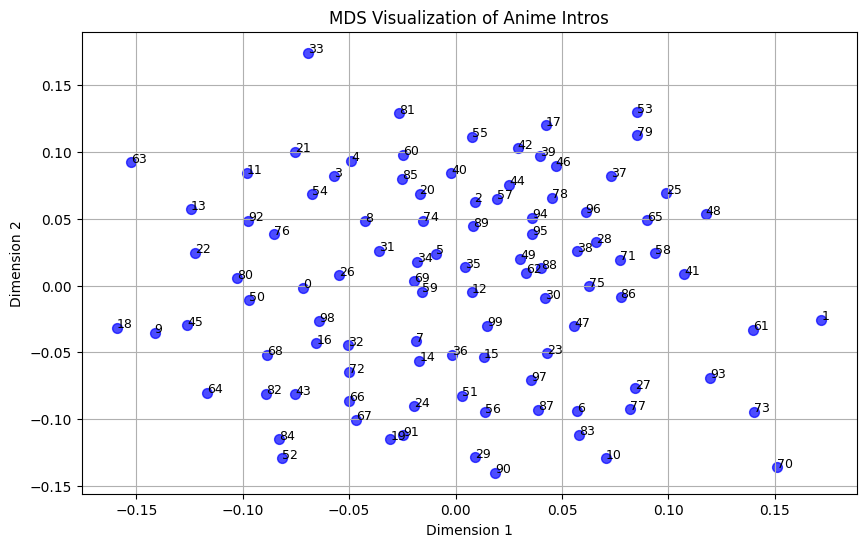

In [40]:
# Plot the MDS results
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['x'], df_sub['y'], s=50, c='blue', alpha=0.7)

# Annotate points with anime names
for i, name in enumerate(df_sub['name']):
    plt.text(df_sub['x'][i], df_sub['y'][i], i, fontsize=9)

plt.title("MDS Visualization of Anime Intros")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

In [93]:
cosine_sim[29, 90]

np.float64(0.8241626157277845)

In [94]:
df_sub.iloc[[29, 90]]

,name,intro,intro_feature,x,y
29,一兆＄遊戲,阿陽是個狡猾且頭腦靈活的人，而阿學則是個性格內向、不擅長與人交談的電腦迷。這兩個性格完全相反...,"[0.7174503207206726, 0.3652258515357971, 0.631...",0.008981,-0.128756
90,聲優廣播的幕前幕後,「夕陽與～」「夜澄的！...預備——」「高中生廣播～！」 \r碰巧就讀同一間高中的好姊妹聲優...,"[0.669806718826294, 1.0578798055648804, 0.2169...",0.018562,-0.140200


In [91]:
df_sub.loc[27, 'intro']

'傳說中的牛媽又回來啦！\r「農家的常識並非社會的常識」荒川弘在成為漫畫家之前，於北海道老家當了七年的酪農兼農民。全年無休的工作，專職養牛和種菜。過著怕被熊咬，被蝦夷縞栗鼠耍得團團轉的日常生活。她將繼續讓你掌握日本酪農與農業辛酸的現實狀況，同時見識到揮灑汗水賣力工作的成年人（有時是兒童），充滿歡笑與活力滿點的酷炫生活方式！'

In [92]:
df_sub.loc[77, 'intro']

'因工作繁忙而沒有多餘心力做家事的小杉拓馬，在回收店買了一台家務機器人米娜。原本以為買回來的只是一台「不具感情」的家事機器人，沒想到在拓馬一次出於真心的醉話「你願意做我的妻子嗎？」之後，米娜開始出現異常的行為……。機器人是否真的不會具有感情，也沒有「心靈」可言？因見面與言語的命運邂逅，由此開始了孤單成年男子與家電機器人的溫暖互動。'

In [54]:
df_sub['name']

0                       青之壬生浪
1                      香蕉喵遊世界
2              平凡職業造就世界最強 第三季
3     香格里拉・開拓異境～糞作獵手挑戰神作～ 第二季
4                     魔王 2099
               ...           
95               死神少爺與黑女僕 第三季
96              轉生貴族憑鑑定技能扭轉人生
97         蔚藍檔案 The Animation
98                  夜晚的水母不會游泳
99                     夜櫻家大作戰
Name: name, Length: 100, dtype: object